# DAPT 612: Text Mining
## Assignment 1: Part 1
Brie Dubinsky, Group 3

In [1]:
from collections import OrderedDict
import csv
from elasticsearch import helpers, Elasticsearch as es
import en_core_web_sm
#import gensim.downloader as gensim_api
#import gensim
# import langdetect
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
#from pprint import pprint
import re
import requests
#from sklearn import feature_extraction, manifold
import spacy
#from spacy.matcher import Matcher
import string
from textblob import TextBlob
import texthero as hero
import textacy
from textacy import preprocessing, extract
import seaborn as sns
#import wordcloud
#from wordcloud import STOPWORDS
nlp = en_core_web_sm.load()
#matcher = Matcher(nlp.vocab)

# LOCAL_REPOSITORY_LOCATION = os.environ.get('LOCAL_REPOSITORY_LOCATION')

# os.chdir(r'C:\Users\short\Documents\LOCAL_REPOSITORY_LOCATION\612_TextMining')

# print(os.getcwdb())

#nltk.download('punkt')

#nltk.download('averaged_perceptron_tagger')

In [2]:
# read in the file
df1 = pd.read_csv('eval_data_dapt.csv', encoding = 'utf-8', dtype = str)

# read in the lookup values
df2 = pd.read_excel(r'competency_definitions.xlsx', sheet_name = 0)

df3 = pd.merge(df1, df2, on = 'epa_number', how = 'left')

df3 = df3[['eval_id', 'student_id', 'gender', 'course', 'preceptor', 'epa_number', 'display_label', 'rating_score', 'rating_label', 'comments']]

data = df3.copy(deep = False)

data.head(1)

eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   

                             rating_label  \
0  I had to prompt them from time to time   

                                            comments  
0  Work on your interview structure. Keep it cons...

# Description of the data set
This dataset represents a behavioral assessment of medical student clinical performance. Students receive these evaluations once a week from the supervising physicians who teach them. This assessment is similar to a workplace-based assessment (WBA) and provides students with a real-time understanding of their performance on 13 core clinical skills (<a href="https://www.aamc.org/what-we-do/mission-areas/medical-education/cbme/core-epas">entrustable professional activities</a>). The evaluation utilizes a modified version of the Ottawa Clinic Assessment Scale (<a href="https://pubmed.ncbi.nlm.nih.gov/27052202/">OCAT</a>) to describe the student's readiness for independent practice. In this dataset, the rating values range from 1 (_I had to do it for them_) to 5 (_I did not need to be there_).

In [3]:
data.head(3)

eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   
1   55453        855      M  Pediatrics  Attending      EPA 6   
2   56658        855      M  Pediatrics  Attending      EPA 2   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   
1  Provide an Oral Presentation of a Clinical Enc...            3   
2  Prioritize a Differential Diagnosis Following ...            4   

                             rating_label  \
0  I had to prompt them from time to time   
1  I had to prompt them from time to time   
2   I needed to be available just in case   

                                            comments  
0  Work on your interview structure. Keep it cons...  
1  Develop ED focused presentation skills by pres...  
2          Watch as many physical exams as possible

In [4]:
data['epa_number'].unique()

array(['EPA 1', 'EPA 6', 'EPA 2', 'EPA 3', 'EPA 5', 'EPA 9', 'EPA 7',
       'EPA 8', 'EPA 4', 'EPA 11', 'EPA 13', 'EPA 10', 'EPA 12'],
      dtype=object)

In [5]:
data['display_label'].unique()

array(['Gather a History and Perform a Physical Examination',
       'Provide an Oral Presentation of a Clinical Encounter',
       'Prioritize a Differential Diagnosis Following a Clinical Encounter',
       'Recommend and Interpret Common Diagnostic and Screening Tests',
       'Document a Clinical Encounter in the Patient Record',
       'Collaborate as a Member of an Interprofessional Team',
       'Form Clinical Questions and Retrieve Evidence to Advance Patient Care',
       'Give or Receive a Patient Handover to Transition Care Responsibility',
       'Enter and Discuss Orders and Prescriptions',
       'Obtain Informed Consent for Tests and/or Procedures',
       'Identify System Failures and Contribute to a Culture of Safety and Improvement',
       'Recognize a Patient Requiring Urgent or Emergent Care and Initiate Evaluation and Management',
       'Perform General Procedures of a Physician'], dtype=object)

## Manual pre-processing steps:

 - **Student:** I converted student names to lowercase.
 -  **Course:** I replaced a compound name (`Obstetrics & Gynecology`) with a short name (`Obstetrics`) to improve sorting/tagging.

In [6]:
data['course'] = (data['course'].str.replace('Obstetrics & Gynecology', 'Obstetrics'))

I created a custom pipeline in TextHero that:

 - removes whitespace between words
 - removes common stopwords
 - removes punctuation, diacritics, and digits
 - drops empty rows

I will apply this later, after exploring the raw data further. 

In [7]:
from texthero import preprocessing

custom_pipeline = [preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_digits,
                   preprocessing.drop_no_content]

There are eight core specialties represented in the dataset:

In [8]:
data['course'].unique()

array(['Pediatrics', 'Obstetrics', 'Neurology', 'Psychiatry',
       'Ambulatory', 'Family Medicine', 'Surgery', 'Internal Medicine'],
      dtype=object)

Students receive instruction from supervising senior physicians (attendings), physicians pursuing specialized post-graduate training (residents), and various members of the healthcare team (e.g., nurses).

In [9]:
data.preceptor.unique()

array(['Attending', 'Resident', 'Other'], dtype=object)

# Descriptive statistics

There are 1,240 observations in the dataset, representing evaluations on 22 students. It's interesting that the most frequent comment in the dataset is "no comments," because comments are recorded in a free-text field (i.e., there are no "canned" or pre-populated options). Given the busy pace of work in the hospital, and the high volume of required paperwork they must also complete, this is understandable though not ideal.

In [10]:
data.describe()

eval_id student_id gender             course  preceptor epa_number  \
count     1240       1240   1240               1240       1240       1240   
unique    1240         23      2                  8          3         13   
top      55339       1006      M  Internal Medicine  Attending      EPA 1   
freq         1         82    798                233        596        299   

                                            display_label rating_score  \
count                                                1240         1240   
unique                                                 13            5   
top     Gather a History and Perform a Physical Examin...            4   
freq                                                  299          641   

                                 rating_label     comments  
count                                    1240         1240  
unique                                      5         1120  
top     I needed to be available just in case  No comments  
freq                                      641           38

I was curious to see whether the ratings aligned with qualitative feedback, as most evaluations rate students at a 4 or higher. A small sample reveals some room for improvement and a few common typos. For example, one physician used the shorthand for "patient" ("pt") when perhaps they're referring to the student (StudentID 855). 

In [11]:
data[data['rating_score'] == '5'].head()

eval_id student_id gender      course  preceptor epa_number  \
12   77699        855      M   Neurology  Attending      EPA 6   
15   83903        855      M  Psychiatry   Resident      EPA 2   
16   83904        855      M  Psychiatry   Resident      EPA 2   
17   85335        855      M  Psychiatry   Resident      EPA 7   
19   85978        855      M  Psychiatry   Resident      EPA 1   

                                        display_label rating_score  \
12  Provide an Oral Presentation of a Clinical Enc...            5   
15  Prioritize a Differential Diagnosis Following ...            5   
16  Prioritize a Differential Diagnosis Following ...            5   
17  Form Clinical Questions and Retrieve Evidence ...            5   
19  Gather a History and Perform a Physical Examin...            5   

                  rating_label  \
12  I did not need to be there   
15  I did not need to be there   
16  I did not need to be there   
17  I did not need to be there   
19  I did not need to be there   

                                             comments  
12  Pt would easily become independent with additi...  
15                                   Doing a good job  
16                                   Doing a good job  
17                         continuing to do good work  
19                   Very thorough. Doing a great job

## Checking for missing values

We don't have any missing values in this data set, which simplifies some steps for cleaning.

In [12]:
data.isna().sum()

eval_id          0
student_id       0
gender           0
course           0
preceptor        0
epa_number       0
display_label    0
rating_score     0
rating_label     0
comments         0
dtype: int64

# Are students evaluated more often in some competencies than others?
There seems to be a preference for evaluating students in their history and physical exam (EPA 1), oral presentations (EPA 6), clinical documentation (EPA 5), and differential diagnosis (EPA 2). This makes sense, because many of the less utilized competencies represent complex tasks that students may not be authorized to perform in every setting.

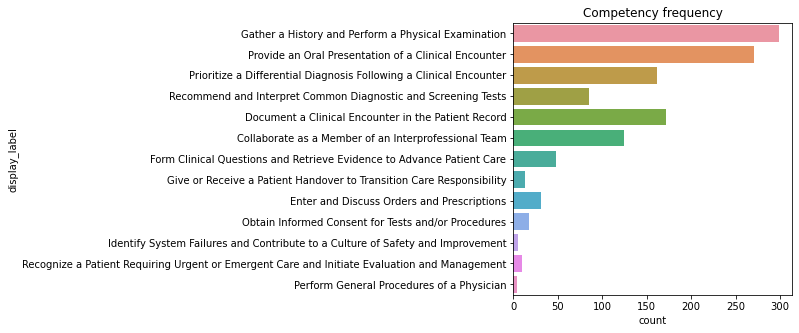

In [13]:
total = len(data)

plt.figure(figsize = (5, 5))
plt.title('Competency frequency')
ax = sns.countplot(y = 'display_label', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

# Visualize the comments in a word cloud

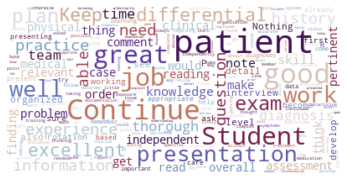

In [15]:
# https://amueller.github.io/word_cloud/auto_examples/simple.html
# https://www.python-graph-gallery.com/wordcloud/
# https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS

# collect the comments
comment = " ".join(comment for comment in data.comments)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

Based on the information visualized in the wordcloud, I decided to incorporate key words, like "patient" and "student" into the list of stopwords.

In [16]:
wn = nltk.WordNetLemmatizer()

# Create function for text cleaning 
def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords] 
    return text

data['words'] = data['comments'].apply(lambda x: clean_text(str(x)))

# Define extra stopwords
extra_stopwords = ['history', 'h', 'p', 'sure', 'well', 'patient', 'student', 'exam', 'make']

# Remove extra stopwords  
data.loc[:,'words'] = data['words'].apply(lambda x: [word for word in x if word not in extra_stopwords])

In [17]:
data[['comments', 'words']].head(5)

comments  \
0  Work on your interview structure. Keep it cons...   
1  Develop ED focused presentation skills by pres...   
2          Watch as many physical exams as possible    
3  Should work on being more methodical in collec...   
4  Did well reorganizing the assessment by proble...   

                                               words  
0  [work, interview, structure, keep, consistent,...  
1  [develop, ed, focused, presentation, skill, pr...  
2                  [watch, many, physical, possible]  
3  [work, methodical, collecting, information, pr...  
4  [reorganizing, assessment, problem, plan, prob...

As I experimented with various NLP packages, I opted to preserve the "raw comments" and added a new column for comments I passed through the TextHero preprocessing pipleline.

In [18]:
data['comments_clean'] = data['comments']

# clean the comments but preserve the original comments
data['comments_clean'] = hero.clean(data['comments_clean'], custom_pipeline)

data.head(10)

eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   
1   55453        855      M  Pediatrics  Attending      EPA 6   
2   56658        855      M  Pediatrics  Attending      EPA 2   
3   57949        855      M  Pediatrics  Attending      EPA 3   
4   62690        855      M  Pediatrics  Attending      EPA 5   
5   62692        855      M  Pediatrics  Attending      EPA 9   
6   63905        855      M  Obstetrics  Attending      EPA 9   
7   64208        855      M  Obstetrics   Resident      EPA 6   
8   65824        855      M  Obstetrics  Attending      EPA 6   
9   68077        855      M  Obstetrics   Resident      EPA 7   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   
1  Provide an Oral Presentation of a Clinical Enc...            3   
2  Prioritize a Differential Diagnosis Following ...            4   
3  Recommend and Interpret Common Diagnostic and ...            3   
4  Document a Clinical Encounter in the Patient R...            3   
5  Collaborate as a Member of an Interprofessiona...            4   
6  Collaborate as a Member of an Interprofessiona...            3   
7  Provide an Oral Presentation of a Clinical Enc...            3   
8  Provide an Oral Presentation of a Clinical Enc...            3   
9  Form Clinical Questions and Retrieve Evidence ...            3   

                             rating_label  \
0  I had to prompt them from time to time   
1  I had to prompt them from time to time   
2   I needed to be available just in case   
3  I had to prompt them from time to time   
4  I had to prompt them from time to time   
5   I needed to be available just in case   
6  I had to prompt them from time to time   
7  I had to prompt them from time to time   
8  I had to prompt them from time to time   
9  I had to prompt them from time to time   

                                            comments  \
0  Work on your interview structure. Keep it cons...   
1  Develop ED focused presentation skills by pres...   
2          Watch as many physical exams as possible    
3  Should work on being more methodical in collec...   
4  Did well reorganizing the assessment by proble...   
5  I think it's great to get involved with what p...   
6  Present, scrubbed and engaged for a hysterecto...   
7  Needs to work on physical exam skills and orga...   
8  This was a presentation for a case based teach...   
9             Doing just fine for a new third year.    

                                               words  \
0  [work, interview, structure, keep, consistent,...   
1  [develop, ed, focused, presentation, skill, pr...   
2                  [watch, many, physical, possible]   
3  [work, methodical, collecting, information, pr...   
4  [reorganizing, assessment, problem, plan, prob...   
5  [think, great, get, involved, physical, therap...   
6  [present, scrubbed, engaged, hysterectomy, ask...   
7  [need, work, physical, skill, organizing, pres...   
8  [presentation, case, based, teaching, conferen...   
9                           [fine, new, third, year]   

                                      comments_clean  
0  Work   interview structure  Keep  consistent  ...  
1  Develop ED focused presentation skills  presen...  
2               Watch  many physical exams  possible  
3  Should work    methodical  collecting informat...  
4  Did well reorganizing  assessment  problem   p...  
5  I think   great  get involved   physical thera...  
6  Present  scrubbed  engaged   hysterectomy  Ask...  
7  Needs  work  physical exam skills  organizing ...  
8  This   presentation   case based teaching conf...  
9                      Doing  fine   new third year

# Visualizing top words associated with high/low evaluation ratings

Text(0.5, 1.0, 'Words used often in evaluations with high ratings')

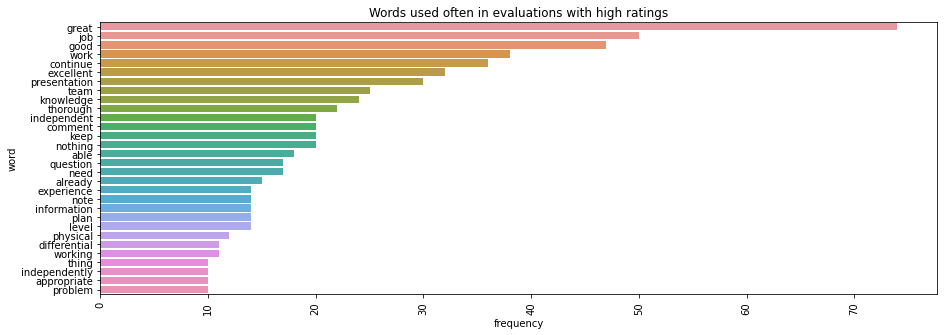

In [19]:
from collections import Counter

high_rating = list(data.loc[data.rating_score == '5', 'words'])

# Flatten list of lists
high_rating = list(np.concatenate(high_rating).flat)

# Create dictionary to store word frequency
high_rating = Counter(high_rating)
hr_words = pd.DataFrame(high_rating.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = hr_words, ax = ax)
plt.xticks(rotation = '90')
plt.title('Words used often in evaluations with high ratings')

The results make sense, given that lower ratings indicate that the student's skills are developing. Words like _continue_ and _practice_ reflect this.

Text(0.5, 1.0, 'Words used often in evaluations with low ratings')

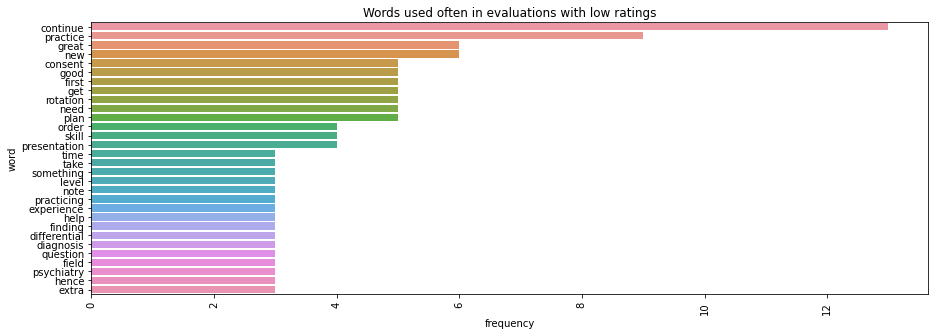

In [20]:
low_rating = list(data.loc[data.rating_score < '3', 'words'])

# Flatten list of lists
low_rating = list(np.concatenate(low_rating).flat)

# Create dictionary to store word frequency
low_rating = Counter(low_rating)
lr_words = pd.DataFrame(low_rating.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = lr_words, ax = ax)
plt.xticks(rotation = '90')
plt.title('Words used often in evaluations with low ratings')

# Visualizing top words associated evaluation ratings by GENDER

In [21]:
# female & male df's:
dff = data[data.gender == 'F']
dfm = data[data.gender == 'M']

#female & male / high & low scores df's:
dffh = data[(data.gender == 'F') & (data.rating_score == '5')]
dffl = data[(data.gender == 'F') & (data.rating_score < '3')]

dfmh = data[(data.gender == 'M') & (data.rating_score == '5')]
dfml = data[(data.gender == 'M') & (data.rating_score < '3')]

In [23]:
print(dff.shape)
print(dfm.shape)
print(dffh.shape)
print(dfmh.shape)
print(dffl.shape)
print(dfml.shape)

(442, 12)
(798, 12)
(133, 12)
(198, 12)
(9, 12)
(24, 12)


In [312]:
# WORD COUNTER: FEMALES (ALL SCORES)

from collections import Counter

words_f = list(dff.words)

# Flatten list of lists
words_f = list(np.concatenate(words_f).flat)

# Create dictionary to store word frequency
words_f = Counter(words_f)
words_f2 = pd.DataFrame(words_f.most_common(30), columns = ['word', 'frequency'])

# WORD COUNTER: MALES (ALL SCORES)

from collections import Counter

words_m = list(dfm.words)

# Flatten list of lists
words_m = list(np.concatenate(words_m).flat)

# Create dictionary to store word frequency
words_m = Counter(words_m)
words_m2 = pd.DataFrame(words_m.most_common(30), columns = ['word', 'frequency'])

# WORD COUNTER: FEMALES (HIGH SCORES)

words_fh = list(dffh.words)

# Flatten list of lists
words_fh = list(np.concatenate(words_fh).flat)

# Create dictionary to store word frequency
words_fh = Counter(words_fh)
words_fh2 = pd.DataFrame(words_fh.most_common(30), columns = ['word', 'frequency'])


# WORD COUNTER: MALES (HIGH SCORES)

from collections import Counter

words_mh = list(dfmh.words)

# Flatten list of lists
words_mh = list(np.concatenate(words_mh).flat)

# Create dictionary to store word frequency
words_mh = Counter(words_mh)
words_mh2 = pd.DataFrame(words_mh.most_common(30), columns = ['word', 'frequency'])



# WORD COUNTER: FEMALES (LOW SCORES)

words_fl = list(dffl.words)

# Flatten list of lists
words_fl = list(np.concatenate(words_fl).flat)

# Create dictionary to store word frequency
words_fl = Counter(words_fl)
words_fl2 = pd.DataFrame(words_fl.most_common(30), columns = ['word', 'frequency'])



# WORD COUNTER: MALES (LOW SCORES)

from collections import Counter

words_ml = list(dfml.words)

# Flatten list of lists
words_ml = list(np.concatenate(words_ml).flat)

# Create dictionary to store word frequency
words_ml = Counter(words_ml)
words_ml2 = pd.DataFrame(words_ml.most_common(30), columns = ['word', 'frequency'])

Text(0.5, 1.0, 'MALES: Words used often in LOW RATING evaluations (male students: 798)')

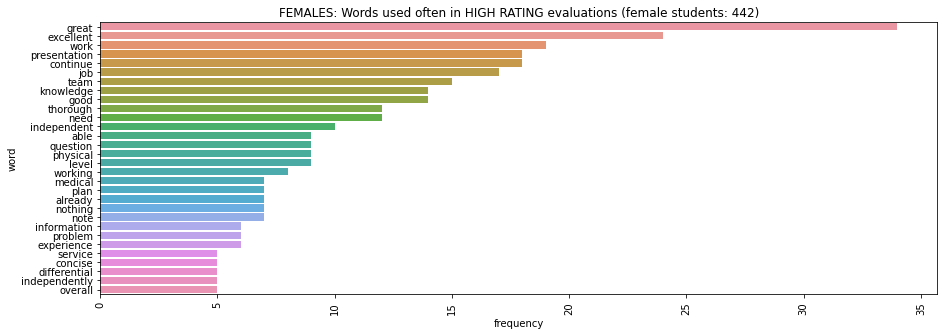

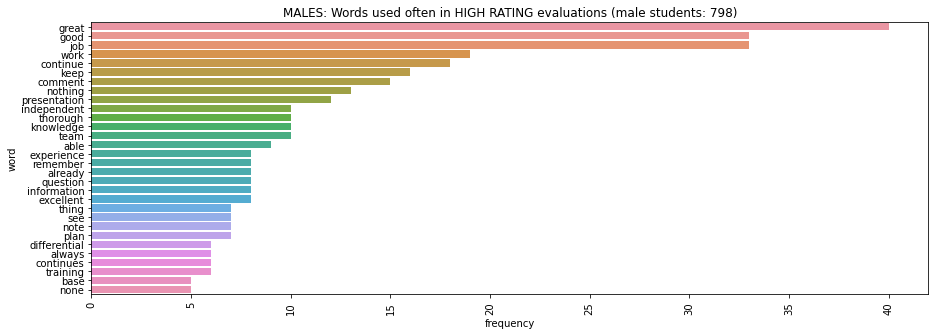

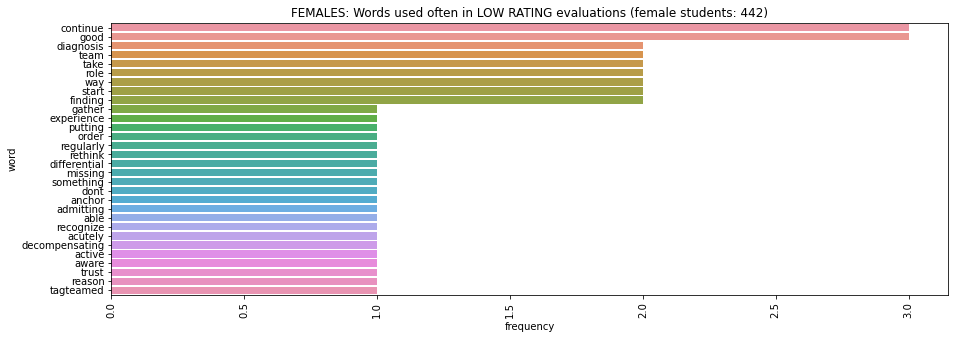

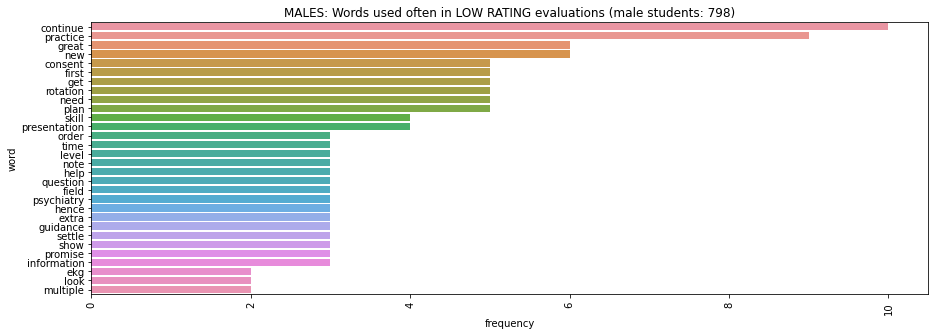

In [313]:
# plot most common words related to the H&P competency
n_females = dff.gender.count()
n_males = dfm.gender.count()

# # females all scores
# fig, ax = plt.subplots(figsize = (15, 5))
# sns.barplot(x = 'frequency', y = 'word', data = words_f2, ax = ax)
# plt.xticks(rotation = '90')
# plt.title(f'FEMALES: Words used often in evaluations (female students: {n_females})')

# # males all scores
# fig, ax = plt.subplots(figsize = (15, 5))
# sns.barplot(x = 'frequency', y = 'word', data = words_m2, ax = ax)
# plt.xticks(rotation = '90')
# plt.title(f'MALES: Words used often in evaluations (male students: {n_males})')

#females high scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_fh2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'FEMALES: Words used often in HIGH RATING evaluations (female students: {n_females})')

#males high scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_mh2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'MALES: Words used often in HIGH RATING evaluations (male students: {n_males})')

#females low scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_fl2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'FEMALES: Words used often in LOW RATING evaluations (female students: {n_females})')

#males low scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_ml2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'MALES: Words used often in LOW RATING evaluations (male students: {n_males})')

In [317]:
# capture 100 most common words in evaluations from each gender, HIGH & LOW rating evals

# top 100 words from ALL evals
words_f3 = pd.DataFrame(words_f.most_common(100), columns = ['word', 'frequency'])
words_m3 = pd.DataFrame(words_m.most_common(100), columns = ['word', 'frequency'])

# top 100 words from HIGH evals
words_fh3 = pd.DataFrame(words_fh.most_common(100), columns = ['word', 'frequency'])
words_mh3 = pd.DataFrame(words_mh.most_common(100), columns = ['word', 'frequency'])

# top 100 words from LOW evals
words_fl3 = pd.DataFrame(words_fl.most_common(100), columns = ['word', 'frequency'])
words_ml3 = pd.DataFrame(words_ml.most_common(100), columns = ['word', 'frequency'])

In [327]:
pd.options.display.float_format = '{}'.format

words_ml3

word  frequency  rank_m
0    continue         10     1.0
1    practice          9     2.0
2       great          6     3.0
3         new          6     3.0
4     consent          5     4.0
..        ...        ...     ...
95  assessing          1     8.0
96       harm          1     8.0
97    develop          1     8.0
98       self          1     8.0
99   directed          1     8.0

[100 rows x 3 columns]

In [328]:
# rank top words for each gender ALL evals
words_f3['rank_f'] = words_f3.frequency.rank(method = 'dense', ascending = False)
words_m3['rank_m'] = words_m3.frequency.rank(method = 'dense', ascending = False)

# merge top female & top male words ALL evals
words_fm = pd.merge(words_f3, words_m3, on = 'word', how = 'outer')

# rank top words for each gender HIGH SCORE evals
words_fh3['rank_f'] = words_fh3.frequency.rank(method = 'dense', ascending = False)
words_mh3['rank_m'] = words_mh3.frequency.rank(method = 'dense', ascending = False)

# merge top female & top male words HIGH SCORE evals
words_fmh = pd.merge(words_fh3, words_mh3, on = 'word', how = 'outer')

# rank top words for each gender LOW SCORE evals
words_fl3['rank_f'] = words_fl3.frequency.rank(method = 'dense', ascending = False)
words_ml3['rank_m'] = words_ml3.frequency.rank(method = 'dense', ascending = False)

# merge top female & top male words LOW SCORE evals
words_fml = pd.merge(words_fl3, words_ml3, on = 'word', how = 'outer')



In [329]:
# rename columns (female/male) ALL evals
words_fm.rename(columns = {'frequency_x': 'female_freq', 'frequency_y':'male_freq'}, inplace = True)

# rename columns (female/male) HIGH evals
words_fmh.rename(columns = {'frequency_x': 'female_freq', 'frequency_y':'male_freq'}, inplace = True)

# rename columns (female/male) LOW evals
words_fml.rename(columns = {'frequency_x': 'female_freq', 'frequency_y':'male_freq'}, inplace = True)


In [330]:
# common & unique words between female / male students ALL evals

common = words_fm[(words_fm.female_freq.notnull()) & (words_fm.male_freq.notnull())]
unique = words_fm[(words_fm.female_freq.isna()) | (words_fm.male_freq.isna())]
unique_f = unique[unique.female_freq.notnull()]
unique_m = unique[unique.male_freq.notnull()]

unique_f.drop(columns = ['male_freq', 'rank_m'], inplace = True)
unique_m.drop(columns = ['female_freq', 'rank_f'], inplace = True)


# common & unique words between female / male students HIGH evals

commonh = words_fmh[(words_fmh.female_freq.notnull()) & (words_fmh.male_freq.notnull())]
uniqueh = words_fmh[(words_fmh.female_freq.isna()) | (words_fmh.male_freq.isna())]
unique_fh = uniqueh[uniqueh.female_freq.notnull()]
unique_mh = uniqueh[uniqueh.male_freq.notnull()]

unique_fh.drop(columns = ['male_freq', 'rank_m'], inplace = True)
unique_mh.drop(columns = ['female_freq', 'rank_f'], inplace = True)


# common & unique words between female / male students LOW evals

commonl = words_fml[(words_fml.female_freq.notnull()) & (words_fml.male_freq.notnull())]
uniquel = words_fm[(words_fml.female_freq.isna()) | (words_fml.male_freq.isna())]
unique_fl = uniquel[uniquel.female_freq.notnull()]
unique_ml = uniquel[uniquel.male_freq.notnull()]

unique_fl.drop(columns = ['male_freq', 'rank_m'], inplace = True)
unique_ml.drop(columns = ['female_freq', 'rank_f'], inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\clark\AppData\Local\Temp/ipykernel_21536/3960865218.py:26: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Words in top 100 most common words from ALL evaluations that are unique to FEMALES


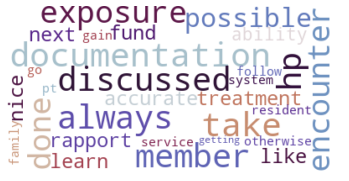

Words in top 100 most common words from ALL evaulations that are unique to MALES


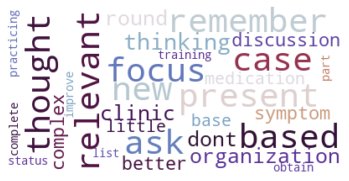

Words in top 100 most common words from HIGH SCORING evaluations that are unique to FEMALES


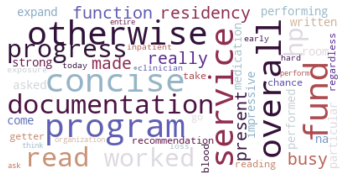

Words in top 100 most common words from HIGH SCORING evaulations that are unique to MALES


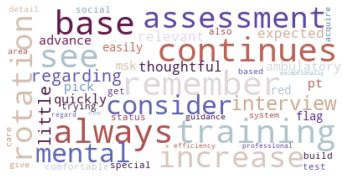

Words in top 100 most common words from LOW SCORING evaluations that are unique to FEMALES


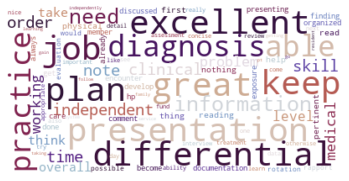

Words in top 100 most common words from LOW SCORING evaulations that are unique to MALES


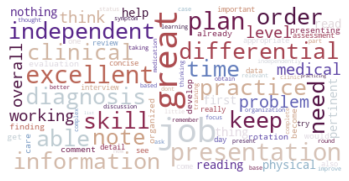

In [332]:
# word clouds 

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS

# Words unique to FEMALES' evaluations (in most 100 common words) ALL EVALS

comment = " ".join(comment for comment in unique_f.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from ALL evaluations that are unique to FEMALES')
plt.show()

# Words unique to MALES' evaluations (in most 100 common words) ALL EVALS

comment = " ".join(comment for comment in unique_m.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from ALL evaulations that are unique to MALES')
plt.show()

# Words unique to FEMALES' evaluations (in most 100 common words) HIGH EVALS

comment = " ".join(comment for comment in unique_fh.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from HIGH SCORING evaluations that are unique to FEMALES')
plt.show()

# Words unique to MALES' evaluations (in most 100 common words) HIGH EVALS
comment = " ".join(comment for comment in unique_mh.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from HIGH SCORING evaulations that are unique to MALES')
plt.show()

# Words unique to FEMALES' evaluations (in most 100 common words) LOW EVALS
comment = " ".join(comment for comment in unique_fl.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from LOW SCORING evaluations that are unique to FEMALES')
plt.show()

# Words unique to MALES' evaluations (in most 100 common words) LOW EVALS
comment = " ".join(comment for comment in unique_ml.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from LOW SCORING evaulations that are unique to MALES')
plt.show()

In [289]:
# COUNT / PCT of FEMALES per course 
dffc = pd.DataFrame(dff.groupby('course').count().eval_id)
dffc.reset_index(inplace = True)
dffc.rename(columns = {'eval_id': 'female'}, inplace = True)
dffc['female_pct'] = dffc.female / dffc.female.sum()

# COUNT / PCT of MALES per course 
dfmc = pd.DataFrame(dfm.groupby('course').count().eval_id)
dfmc.reset_index(inplace = True)
dfmc.rename(columns = {'eval_id': 'male'}, inplace = True)
dfmc['male_pct'] = dfmc.male / dfmc.male.sum()

# format
pd.options.display.float_format = '{:.1%}'.format

# merge data
dfc = pd.merge(dffc, dfmc, on = 'course', how = 'inner')

dfc

course  female  female_pct  male  male_pct
0         Ambulatory      57       12.9%   119     14.9%
1    Family Medicine      50       11.3%   127     15.9%
2  Internal Medicine      92       20.8%   141     17.7%
3          Neurology      26        5.9%    50      6.3%
4         Obstetrics      47       10.6%    50      6.3%
5         Pediatrics      49       11.1%    93     11.7%
6         Psychiatry      64       14.5%   140     17.5%
7            Surgery      57       12.9%    78      9.8%

Text(0.5, 1.0, 'MALES: Words used often in evaluations with HIGH ratings')

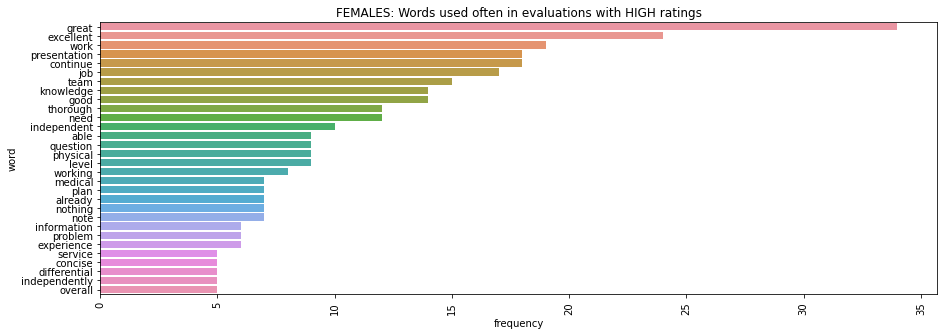

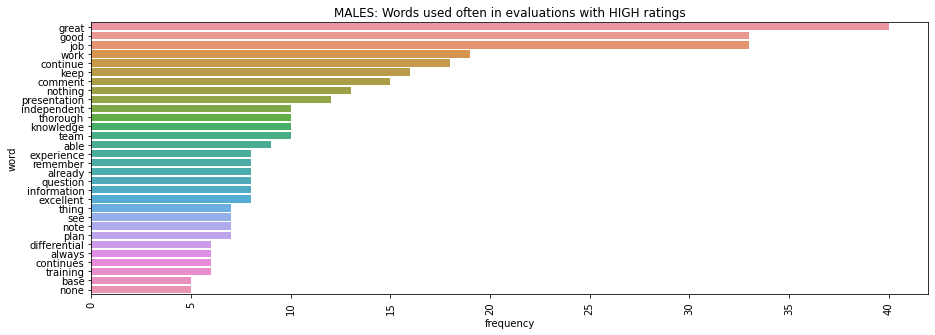

In [290]:
# WORD COUNTER: FEMALES (HIGH SCORES)

from collections import Counter

high_rating_f = list(dff.loc[dff.rating_score == '5', 'words'])

# Flatten list of lists
high_rating_f = list(np.concatenate(high_rating_f).flat)

# Create dictionary to store word frequency
high_rating_f = Counter(high_rating_f)
hr_words_f = pd.DataFrame(high_rating_f.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = hr_words_f, ax = ax)
plt.xticks(rotation = '90')
plt.title('FEMALES: Words used often in evaluations with HIGH ratings')


# WORD COUNTER: MALES (HIGH SCORES)

high_rating_m = list(dfm.loc[dfm.rating_score == '5', 'words'])

# Flatten list of lists
high_rating_m = list(np.concatenate(high_rating_m).flat)

# Create dictionary to store word frequency
high_rating_m = Counter(high_rating_m)
hr_words_m = pd.DataFrame(high_rating_m.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = hr_words_m, ax = ax)
plt.xticks(rotation = '90')
plt.title('MALES: Words used often in evaluations with HIGH ratings')

Text(0.5, 1.0, 'MALES: Words used often in evaluations with LOW ratings')

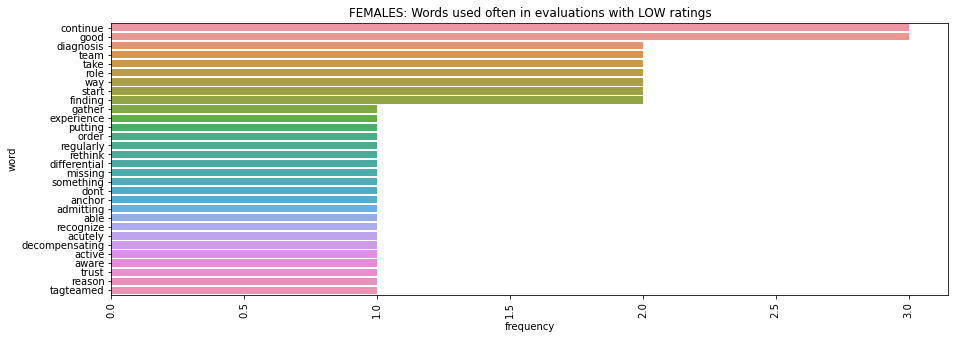

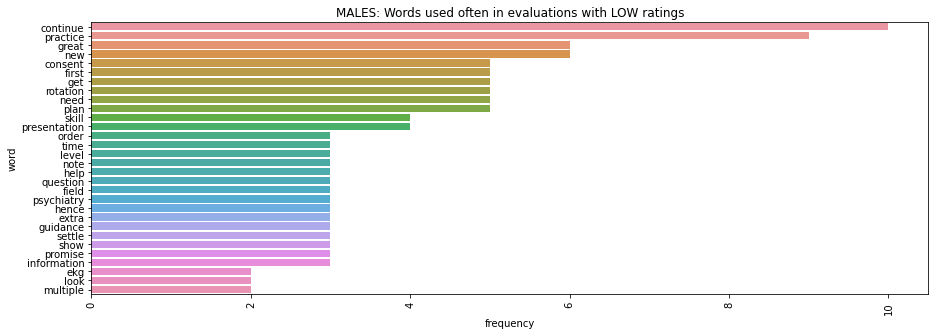

In [279]:
# WORD COUNTER: FEMALES (LOW SCORES)


low_rating_f = list(dff.loc[dff.rating_score < '3', 'words'])

# Flatten list of lists
low_rating_f = list(np.concatenate(low_rating_f).flat)

# Create dictionary to store word frequency
low_rating_f = Counter(low_rating_f)
lr_words_f = pd.DataFrame(low_rating_f.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = lr_words_f, ax = ax)
plt.xticks(rotation = '90')
plt.title('FEMALES: Words used often in evaluations with LOW ratings')


# WORD COUNTER: MALES (LOW SCORES)

low_rating_m = list(dfm.loc[dfm.rating_score < '3', 'words'])

# Flatten list of lists
low_rating_m = list(np.concatenate(low_rating_m).flat)

# Create dictionary to store word frequency
low_rating_m = Counter(low_rating_m)
lr_words_m = pd.DataFrame(low_rating_m.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = lr_words_m, ax = ax)
plt.xticks(rotation = '90')
plt.title('MALES: Words used often in evaluations with LOW ratings')

# SQL Lite

As I was exploring different techniques, I came across a suggestion to utilize SQL Lite (<a href="https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html">Albrecht, Ramachanran, & Winkler</a>). I kept this in my final list of steps because it provided additional flexibility to revert back to earlier iterations of the dataframe.

In [23]:
data.columns

Index(['eval_id', 'student_id', 'gender', 'course', 'preceptor', 'epa_number',
       'display_label', 'rating_score', 'rating_label', 'comments', 'words',
       'comments_clean'],
      dtype='object')

In [24]:
column_map = {'course' : 'course', 'student_id' : 'student', 'gender' : 'gender', 'display_label' : 'competency', 
              'rating_label' : 'rating', 'rating_score' : 'rating_score', 'comments': 'comments'
              }

# define remaining columns
columns = [c for c in column_map.keys() if column_map[c] != None]

# select and rename those columns
eval_data = data[columns].rename(columns = column_map)

In [25]:
eval_data.head(3)

course student gender  \
0  Pediatrics     855      M   
1  Pediatrics     855      M   
2  Pediatrics     855      M   

                                          competency  \
0  Gather a History and Perform a Physical Examin...   
1  Provide an Oral Presentation of a Clinical Enc...   
2  Prioritize a Differential Diagnosis Following ...   

                                   rating rating_score  \
0  I had to prompt them from time to time            3   
1  I had to prompt them from time to time            3   
2   I needed to be available just in case            4   

                                            comments  
0  Work on your interview structure. Keep it cons...  
1  Develop ED focused presentation skills by pres...  
2          Watch as many physical exams as possible

In [26]:
import sqlite3
# https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html

db_name = 'evaluation.db'
con = sqlite3.connect(db_name)
eval_data.to_sql('eval', con, 
            index = False, 
            if_exists = 'replace')
con.close()

In [27]:
con = sqlite3.connect(db_name)
sample_evals = pd.read_sql("select competency, rating, comments from eval", con)
con.close()

# Sentiment analysis

I used Spacy, Textacy, and TextBlob for sentiment analysis and named entity recognition (NER).

In [28]:
texts = data['comments'].str.split('\n')

string = ' '.join([str(item) for item in texts])

blob = TextBlob(string)

doc = nlp(string)

In [29]:
from textacy.extract import keyterms as kt

# get key terms
kt.textrank(doc, normalize = "lemma", topn = 10)

[('good patient presentation', 0.012947087402218557),
 ('good physical exam finding', 0.009981996926611293),
 ('overall good note writing skill', 0.009370484208071538),
 ('patient present unique opportunity', 0.009264167120135116),
 ('excellent patient evaluation', 0.008705778054775825),
 ('great patient', 0.00864396169398557),
 ('good presentation skill', 0.008578138426080184),
 ('patient need', 0.008430699419498502),
 ('patient information', 0.008412780340643161),
 ('patient history', 0.008399879531708655)]

I extracted the polarity of statements in the dataset, using a random sample.

In [30]:
# https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f

sample = sample_evals.sample(frac = 0.8, replace = False, random_state = 1)

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

sample['polarity'] = sample.comments.apply(detect_polarity)

In [31]:
sample.head(10)

competency  \
119   Recommend and Interpret Common Diagnostic and ...   
202   Collaborate as a Member of an Interprofessiona...   
482   Collaborate as a Member of an Interprofessiona...   
403   Prioritize a Differential Diagnosis Following ...   
259   Gather a History and Perform a Physical Examin...   
167   Gather a History and Perform a Physical Examin...   
940   Provide an Oral Presentation of a Clinical Enc...   
679   Document a Clinical Encounter in the Patient R...   
1076  Document a Clinical Encounter in the Patient R...   
991   Prioritize a Differential Diagnosis Following ...   

                                      rating  \
119   I had to prompt them from time to time   
202    I needed to be available just in case   
482    I needed to be available just in case   
403   I had to prompt them from time to time   
259               I did not need to be there   
167               I did not need to be there   
940    I needed to be available just in case   
679    I needed to be available just in case   
1076              I did not need to be there   
991    I needed to be available just in case   

                                               comments  polarity  
119                                          doing well  0.000000  
202                               Experience with time   0.000000  
482   Continue seeing patients and developing differ...  0.000000  
403   Continue to familiarize yourself with DSM5 cri... -0.118750  
259                                         No comments  0.000000  
167                Good recognition of MSK and good DPX  0.700000  
940   Great at obtaining relevant information. Just ...  0.225455  
679                             Continue to practice.    0.000000  
1076  Excellent documentation of your call with her ...  0.300000  
991          Did well on a fairly complicated patient.  -0.500000

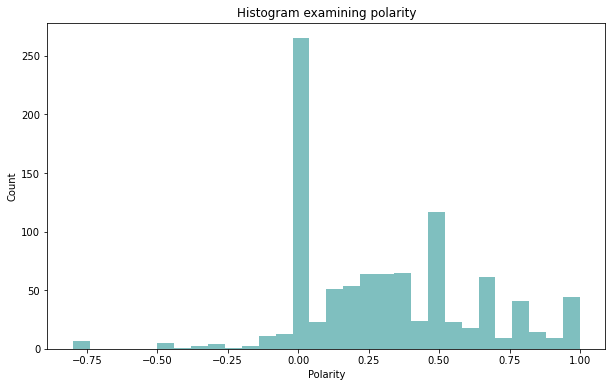

In [32]:
num_bins = 30
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(sample.polarity, num_bins, facecolor = 'teal', alpha = 0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram examining polarity')
plt.show();

It seems to be correctly flagging words like "excellent", and it's interesting to see that these are associated with the highest possible rating (_I did not need to be there_).

In [33]:
sample[sample.polarity > .30].head(5)

competency  \
167   Gather a History and Perform a Physical Examin...   
1076  Document a Clinical Encounter in the Patient R...   
65    Form Clinical Questions and Retrieve Evidence ...   
831   Gather a History and Perform a Physical Examin...   
815   Prioritize a Differential Diagnosis Following ...   

                                      rating  \
167               I did not need to be there   
1076              I did not need to be there   
65                I did not need to be there   
831   I had to prompt them from time to time   
815               I did not need to be there   

                                               comments  polarity  
167                Good recognition of MSK and good DPX  0.700000  
1076  Excellent documentation of your call with her ...  0.300000  
65                                good job on this task  0.700000  
831   Continue to synthesize patient information as ...  0.366667  
815    creates excellent differentials and is a very...  0.760000

Neutral statements are more mixed in quality--again, _no comments_ surfaces. It's not surprising to see that ratings skew a little high, in general.

In [34]:
sample[sample.polarity == 0].head(5)

competency  \
119  Recommend and Interpret Common Diagnostic and ...   
202  Collaborate as a Member of an Interprofessiona...   
482  Collaborate as a Member of an Interprofessiona...   
259  Gather a History and Perform a Physical Examin...   
679  Document a Clinical Encounter in the Patient R...   

                                     rating  \
119  I had to prompt them from time to time   
202   I needed to be available just in case   
482   I needed to be available just in case   
259              I did not need to be there   
679   I needed to be available just in case   

                                              comments  polarity  
119                                         doing well       0.0  
202                              Experience with time        0.0  
482  Continue seeing patients and developing differ...       0.0  
259                                        No comments       0.0  
679                            Continue to practice.         0.0

In [35]:
sample[sample.polarity < 0].head(5)

competency  \
403   Prioritize a Differential Diagnosis Following ...   
991   Prioritize a Differential Diagnosis Following ...   
575   Recommend and Interpret Common Diagnostic and ...   
1196  Provide an Oral Presentation of a Clinical Enc...   
777   Provide an Oral Presentation of a Clinical Enc...   

                                      rating  \
403   I had to prompt them from time to time   
991    I needed to be available just in case   
575    I needed to be available just in case   
1196   I needed to be available just in case   
777   I had to prompt them from time to time   

                                               comments  polarity  
403   Continue to familiarize yourself with DSM5 cri...  -0.11875  
991          Did well on a fairly complicated patient.   -0.50000  
575   at expected level, just continue to read and s...  -0.10000  
1196  Very clear presentation on an evasive patient....  -0.04250  
777   when there is a missing piece of information o...  -0.10000

In [36]:
# https://stackoverflow.com/questions/67983109/how-can-i-pass-table-or-dataframe-instead-of-text-with-entity-recognition-using
def get_entities(x):
    result = {}
    doc = nlp(x)
    for ent in doc.ents:
        result[ent.label_] = ent.text
    return result

ent_matches = data['comments'].apply(get_entities)

ent_matches

0                                          {}
1                       {'ORG': 'Develop ED'}
2                                          {}
3       {'DATE': 'just beginning third year'}
4                                          {}
                        ...                  
1235                        {'DATE': 'daily'}
1236                                       {}
1237                                       {}
1238                                       {}
1239                                       {}
Name: comments, Length: 1240, dtype: object

In [37]:
sample.describe()

polarity
count  992.000000
mean     0.306842
std      0.325759
min     -0.800000
25%      0.000000
50%      0.275000
75%      0.500000
max      1.000000

I used a few sample phrases to train a small model for sentiment analysis.

In [38]:
from textblob import classifiers

training = [
    ('great job especially beginning third year', 'pos'), 
    ('wonderful building rapport', 'pos'),
    ('handled communication non English speaking family well', 'pos'),
    ('integrates strong organization skills complex scenario', 'pos'),
    ('thorough physical exam Well done', 'pos'),
    ('Great job', 'pos'),
    ('Good job. Continue good work', 'pos'),
    ('Great work, especially early in third year!' , 'pos'),
    ('Presentations could concise organized No need repeat studies imaging already discussed prior days', 'neg'),
    ('Should work on being more methodical in collecting information and presenting so nothing is forgotten or missed.', 'neg'),
    ('Work overall organization material want cover slow slightly allow audience follow discussion readily.', 'neg'),
    ('Great thoughts presented', 'pos'),
    ('Good critical thinking differential diagnosis presentation', 'pos'),
    ('More work needed. Continue reading and practicing.', 'neg'),
    ('Continue work on your knowledge base.', 'neg'),
    ('Asked appropriate questions, but would encourage him to closely observe more and ask only a few key, critical questions especially during surgery when the surgeons may be concentrating.', 'neg'), 
    ('Keep it consistent so you don’t forget things.', 'neg'), 
    ('the plan probably couldve been more streamlined by cutting out the old stuff', 'neg'), 
    ('Increase efficiency patient using interpreter requires intentional  rushed interaction.', 'neg'),
    ('Watch as many physical exams as possible.', 'neg'), 
    ('No comment.', 'neg'),
    ('needs continue work redirecting patient finishing interview timely manner. This comes with practice.', 'neg')]

classifier = classifiers.NaiveBayesClassifier(training)


Then, performing a quick test to see if the model can correctly flag the statement below as positive.

In [48]:
classifier.classify('Wonderful student. Fantastic work!')

'pos'

Reviewing the output, it does a pretty good job, but providing it with richer training data may improve future results.

In [49]:
# https://textblob.readthedocs.io/en/dev/classifiers.html
from textblob import Blobber
from textblob.taggers import NLTKTagger
from textblob.tokenizers import SentenceTokenizer

testing = data['comments'].str.split('\n')

test_data = ' '.join([str(item) for item in testing])

tb = Blobber(pos_tagger = NLTKTagger(), tokenizer = SentenceTokenizer(), classifier = classifier)

blob = tb(test_data)

for s in blob.sentences:
    print(s)
    print(s.classify())

['Work on your interview structure.
pos
Keep it consistent so you don’t forget things.
neg
Obtain history then past medical, surgical, social meds and allergies.
pos
Keep interviewing patients so you can practice. ']
pos
['Develop ED focused presentation skills by presenting the pertinent positives and negatives for each complaint.']
pos
['Watch as many physical exams as possible '] ['Should work on being more methodical in collecting information and presenting so nothing is forgotten or missed.
neg
He is doing a great job, especially for just beginning third year!']
pos
["Did well reorganizing the assessment by problem, the plan probably could've been more streamlined by cutting out the old stuff"] ["I think it's great to get involved with what physical therapy was doing.
neg
Also did well reaching out to ENT. "]
pos
['Present, scrubbed and engaged for a hysterectomy.
pos
Asked appropriate questions, but would encourage him to closely observe more and ask only a few key, critical ques

neg
Read more. ']
pos
['See more patients.
pos
Read more. ']
pos
['He is tracking along appropriately for a MS3.
pos
Excellent presentation skills.
pos
Further improvement and independence are anticipated to come along naturally by seeing patient independently and discussing with the primary resident.']
neg
['He is tracking along appropriately for a MS3.
pos
Excellent presentation skills.
pos
Further improvement and independence are anticipated to come along naturally by seeing patients independently and discussing with the primary resident.']
neg
['Continue to see more patients.
pos
Read more. ']
pos
['Continue to see more patients.
pos
Read more. ']
pos
['More practice.']
pos
['The medical student did an excellent job interviewing a patient who survived a serious suicide attempt.
pos
The interview was well structured and organized, and it gave the student the opportunity to identify a correct differential diagnosis.
pos
The MSE correctly identified the most relevant objective finding

neg
['Keep up the good work! ']
pos
['Excellent presentation skills'] ['H and p ability is strong'] ['excellent documentation with only minor corrections'] ['Working on differentials and prioritizing.
pos
Progressing well'] ['Excellent collaboration and team member'] ['Well developed written evaluation.']
pos
['Demonstrated appropriate curiosity in pursuing answer to a clinical question.  ']
pos
['Good job thinking through patient with lower extremity edema to determine etiology.
pos
Good summary and presentation. ']
pos
['Really impressive explanation and investigation into a patient with possible GPA.
neg
Able to tie together several minor symptoms into a coherent diagnosis.
pos
Without her investigation would likely not have sent ANCA.
pos
Keep up that curiosity and attention to detail!
pos
Fantastic. ']
pos
['Great documentation.
pos
As discussed few minor changes recommended such as including outpatient meds in H&P instead of inpatient meds, using a diagnosis as your problem if po

neg
There were also discharge goals and followup plans in this section, which don't belong here, they belong in the assessment and plan.
pos
You also don't need a brief HPI and a hospital course section...they are the same thing, so this is redundant.
neg
Respiratory exam mentions abnormal lung sounds, but this is the least important part of this exam- need to mention if there is increased respiratory effort (retractions, flaring, grunting, head bobbing, tachypnea) and how the air movement is.
neg
Summary statement in the assessment doesn't need to repeat all his chronic medical problems...can call him medically complex and just include the pertinent medical history.
neg
The assessment also says he is still on 10L HFNC, which is incorrect.
pos
Assessment should include an assessment of his volume status especially since he has HOCM and CKD.
pos
Can make notes more concise by avoiding redundancy- nephrology followup was mentioned twice in the plan.
neg
Look at your entire note everyday 

neg
['Will formulated a thorough list of ddx on a child presenting with hematuria and dysuria.
neg
After UA results, he was able to prioritize most probable dx and we discussed additional labs to send.']
pos
['Will was able to accurately gather information to check developmental milestones and predict the  developmental age of a 15 mth old child during a well check.']
neg
['Excellent work.
pos
Keep on the same path'] ['Keep working on physical exam techniques'] ['Will did a great job communicating the information regarding this patient and making an accurate clinical assessment.']
pos
['No issues on shift.
pos
Well prepared.']
pos
['Will did well with this age group.
pos
It was a complicated patient and he was quite engaged.  ']
pos
['Nothing.
pos
Already very adept at patient evaluation and presentation! ']
pos
['when there is a missing piece of information or understanding, skip explanations of why missed to closing the gap with research (eg, asking the patient for clarification or m

pos
["I concur with Dr. Coe that you should try to remember to present to the family, face them, and use laymen's terms or explain the medical terms"] ['Notes as per other evaluation.']
neg
['Just practice and learning of more practical applications of pathologies.
neg
He is bright and motivated and his knowledge base seems excellent.
neg
His rapport with patients and families is excellent.
pos
He is early in third year so he has plenty of time to work on transitioning that skill set to clinical practice rather than test taking.']
pos
['More reading and practice.
neg
He is using resources effectively to broaden assessments/differential diagnoses and just needs more experience to focus in on the most likely possibilities.']
neg
['Just more practice.
pos
He is already quite independent with this particular practice.']
pos
['Good exam, compassionate. ']
pos
['Good exam, did SLR test.
pos
Discussed about testing strength and sensation. ']
pos
['Working on interview flow, not overusing jarg

pos
['Good - need more clinical experience'] ['Just more practice and clinical experience'] ['Needs more clinical experience. ']
pos
['More experience'] ['More clinical exposure'] ['Need more clinical experience'] ['Need more clinical exposure'] ['More expence'] ['More experience. ']
pos
['More experience'] ['More experience'] ['Great presentation for a complex patient!
pos
Continue to be aware of the ways a patient’s symptoms may affect multiple disease processes and note that as such (i.e.
neg
diarrhea may be uncomfortable for pt but may also lead to renal failure due to dehydration.)']
pos
['Continue to seek out opportunities for patient care and presentations. ']
neg
['Presentations are organized, thorough and succinct.
pos
Engaged and participating on rounds.
pos
Showing evidence of outside reading. ']
pos
['Not quite sure how to fill this one out - I observed Student perform a bedside presentation with a patient - did a great job interacting with the patient, learning how to adju

Doing a great job.
pos
Picks up on things quickly. ']
pos
['He continues to advance in his Ambulatory training.
pos
Doing a great job.
pos
Picks up on things quickly. ']
pos
['He continues to advance in his Ambulatory training.
pos
Doing a great job.
pos
Picks up on things quickly. ']
pos
['He continues to advance in his Ambulatory training.
pos
Doing a great job.
pos
Picks up on things quickly. ']
pos
['Knowledge- he has the skills to do it but would just need more time to be completely independent. ']
neg
['He did great!
pos
Just needs more time and experience.']
neg
['Continue to work with the anesthesia team and discuss pertinent findings related to the patient and his/her upcoming case.
neg
Communicate with the nurses.']
pos
['Continue to work on patient interaction and communication in the clinic -- making sure patients understand key instructions.
neg
Doing well!']
pos
['In difficult cases, dig into pathophysiology as needed.
pos
Full understanding changed the differential one p

In [51]:
classifier.show_informative_features(10)

Most Informative Features
    contains(especially) = True              pos : neg    =      2.0 : 1.0
          contains(work) = True              neg : pos    =      1.5 : 1.0
      contains(Continue) = True              neg : pos    =      1.4 : 1.0
         contains(Great) = False             neg : pos    =      1.4 : 1.0
           contains(job) = False             neg : pos    =      1.4 : 1.0
           contains(and) = False             pos : neg    =      1.3 : 1.0
          contains(more) = False             pos : neg    =      1.3 : 1.0
          contains(Good) = False             neg : pos    =      1.2 : 1.0
         contains(third) = False             neg : pos    =      1.2 : 1.0
          contains(year) = False             neg : pos    =      1.2 : 1.0


# PCA with TextHero

In [53]:
import texthero as hero
import pandas as pd

df = data

df['tfidf'] = (
    data['comments']
    .pipe(hero.clean)
    .pipe(hero.tfidf)
)

df['kmeans_labels'] = (
    df['tfidf']
    .pipe(hero.kmeans, n_clusters = 5)
    .astype(str)
)

df['pca'] = df['tfidf'].pipe(hero.pca)

hero.scatterplot(df, 'pca', color = 'kmeans_labels', title = 'K-means')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:786: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


# Entity recognition in Spacy

This aspect of the project took a few iterations. I noticed that Spacy would correctly identify one, or sometimes a few instances of a name (e.g., _Amanda_, but wouldn't flag every instance. There were some misclassifications, like _H&P_ (medical shorthand for "history and physical"), which Spacy identified as an organization.

In the future, I plan to further refine the pre-processing options to replace common medical shorthand with full words. Additionally, I'd like to explore the Spacy library to customize and improve on the model's ability to recognize entities in the data. 

In [59]:
from spacy import displacy

# nlp = spacy.load('en_core_web_trf') # did not work

# spacy.displacy.render(doc, style = 'ent')

In [56]:
# predicting named entities
for ent in doc.ents:
    print(ent.text, ent.label_)

just beginning third year DATE
a new third year DATE
CT ORG
the week DATE
cont GPE
today DATE
Peds ENT ORG
NV ORG
HPI ORG
morning TIME
ROS ORG
two CARDINAL
HPI ORG
OSH ORG
ekgs ORG
MD GPE
MD GPE
today DATE
Easy PERSON
1 CARDINAL
one CARDINAL
ROM ORG
CV GPE
MSK ORG
DPX ORG
this week DATE
Psychoanalytic Diagnosis ORG
3 CARDINAL
one week DATE
the day DATE
One CARDINAL
H & Ps ORG
his 2nd week DATE
UTI ORG
first ORDINAL
3rd ORDINAL
first ORDINAL
the week DATE
first ORDINAL
this week DATE
the day before DATE
CSF ORG
Emporia GPE
VCU ORG
nine-year-old DATE
just one week DATE
first ORDINAL
2 weeks DATE
yesterday DATE
today DATE
today DATE
ER ORG
first ORDINAL
first ORDINAL
first ORDINAL
overnight TIME
few seconds TIME
JVD PERSON
CHF ORG
daily DATE
5-10 minute TIME
14 minutes TIME
today DATE
h&p GPE
at least three CARDINAL
first ORDINAL
5/21 CARDINAL
first ORDINAL
5/21 CARDINAL
DSM 5 ORG
DSM5 NORP
SOAP ORG
first ORDINAL
HPI ORG
first ORDINAL
GI ORG
A&P ORG
SBP ORG
SBP ORG
the past several weeks 

In [57]:
list(extract.keyword_in_context(doc, 'good', window_width = 25, pad_context = True))

[('ther students. He showed ', 'good', ' understanding of a parti'),
 ("y and exam. '] ['Doing a ", 'good', " job'] ['Doing a good job"),
 ("g a good job'] ['Doing a ", 'good', " job'] ['continuing to do"),
 ("job'] ['continuing to do ", 'good', " work'] ['The medical stu"),
 ('e was able to identify a ', 'good', ' differential diagnosis, '),
 ('patient\'s baseline. "] [\'', 'Good', ' differential dx. Continu'),
 ("ifferential and plan'] ['", 'Good', ' recommendation of diagno'),
 ("panding differential'] ['", 'Good', ' interpretation of tests,'),
 (" the situation '] ['Very ", 'good', ' job approaching the toug'),
 ('est case of all of them, ', 'good', ' plans and assessment; wo'),
 ('ts in clinic today. Very ', 'good', ' rapport with patients an'),
 ("tients. '] ['keep up the ", 'good', " work'] ['good job on thi"),
 ("eep up the good work'] ['", 'good', " job on this task'] ['Con"),
 ("uerades in many ways'] ['", 'Good', " history taking'] ['MSK, "),
 ("sider underlying ...'] ['", '

In [58]:
nlp.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False}},
 'problems': {'tok2vec': [],
  'tagger': [],
  'parser': [],
  'attribute_ruler': [],
  'lemmatizer': [],
  'ner': []},
 'att